# Full Inference Pipeline Validation

This notebook validates the complete SAR compression/decompression pipeline against Phase 5 success criteria:

1. **Memory Test**: Large image (4096x4096) processes without OOM
2. **Seamless Blending**: No visible tile boundaries in reconstructed image
3. **PSNR Consistency**: Round-trip PSNR within 0.5 dB of patch-level metrics
4. **Preprocessing Round-Trip**: Inverse preprocessing restores linear values
5. **CLI Smoke Test**: GeoTIFF compress/decompress via CLI with metadata preservation

---

**Model Training Status:**
- Current model: ResNet-Lite v2 (5.6M params)
- Training: 20% data subset, 30 epochs
- Current PSNR: ~21 dB on real SAR data
- Target PSNR: >25 dB

The absolute PSNR values in these tests will improve after more training (Phase 4 completion).
However, the **structural tests** (memory, blending, preprocessing round-trip, CLI) should pass regardless of model quality.

## Cell 1: Setup

In [3]:
import numpy as np
import torch
import time
import json
import os
import tempfile
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt

# Add project root to path
import sys
sys.path.insert(0, str(Path.cwd().parent))

from src.inference import SARCompressor
from src.inference.geotiff import read_geotiff, write_geotiff, GeoMetadata
from src.inference.tiling import create_cosine_ramp_weights, visualize_blend_weights
from src.evaluation.metrics import SARMetrics

# Paths
MODEL_PATH = "checkpoints/resnet_lite_v2_c16/best.pth"
RESULTS_DIR = Path("evaluations")
RESULTS_DIR.mkdir(exist_ok=True)

# Check model exists
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Results collector
results = {
    "test_date": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": MODEL_PATH,
    "tests": {}
}

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## Test 1: Synthetic Large Image (Memory Test)

Test that a 4096x4096 image can be processed without running out of memory.

In [2]:
print("="*60)
print("Test 1: Memory Test (4096x4096 Synthetic Image)")
print("="*60)

# Reset CUDA memory stats
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

# Create synthetic normalized image with cosine patterns (4096x4096)
# This simulates a large SAR scene
size = 4096
y, x = np.mgrid[0:size, 0:size].astype(np.float32)

# Create smooth patterns that look SAR-like (already normalized [0, 1])
image_4k = (
    0.3 + 
    0.25 * np.cos(2 * np.pi * x / 200) * np.cos(2 * np.pi * y / 200) +
    0.15 * np.cos(2 * np.pi * x / 50) * np.cos(2 * np.pi * y / 50) +
    0.1 * np.sin(2 * np.pi * (x + y) / 100)
)
image_4k = np.clip(image_4k, 0, 1).astype(np.float32)

print(f"Created synthetic image: {image_4k.shape}")
print(f"Value range: [{image_4k.min():.3f}, {image_4k.max():.3f}]")
print(f"Memory: {image_4k.nbytes / 1024**2:.1f} MB")

# Initialize compressor
compressor = SARCompressor(
    model_path=MODEL_PATH,
    patch_size=256,
    overlap=64
)
print(f"\nCompressor initialized:")
print(f"  Device: {compressor.device}")
print(f"  Batch size: {compressor.batch_size}")

# Time the compression + decompression
print("\nRunning compression...")
start_time = time.time()

try:
    # We use preprocess + compress since image is already normalized
    # To test the full pipeline, we'll simulate linear SAR data
    # Convert from normalized back to linear for full pipeline test
    vmin, vmax = compressor.preprocess_params['vmin'], compressor.preprocess_params['vmax']
    image_db = image_4k * (vmax - vmin) + vmin
    image_linear = np.power(10.0, image_db / 10.0).astype(np.float32)
    
    # Now do full compress (which includes preprocess)
    latent, metadata = compressor.compress(image_linear)
    compress_time = time.time() - start_time
    print(f"Compression complete: {compress_time:.2f}s")
    print(f"  Latent shape: {latent.shape}")
    print(f"  Tiles: {latent.shape[0]}")
    
    # Decompress
    print("\nRunning decompression...")
    decompress_start = time.time()
    reconstructed = compressor.decompress(latent, metadata)
    decompress_time = time.time() - decompress_start
    print(f"Decompression complete: {decompress_time:.2f}s")
    
    total_time = compress_time + decompress_time
    
    # Memory stats
    if torch.cuda.is_available():
        peak_memory_mb = torch.cuda.max_memory_allocated() / 1024**2
        print(f"\nPeak GPU memory: {peak_memory_mb:.1f} MB")
    else:
        peak_memory_mb = 0
    
    # Verify output shape
    assert reconstructed.shape == image_linear.shape, f"Shape mismatch: {reconstructed.shape} vs {image_linear.shape}"
    print(f"Output shape matches input: {reconstructed.shape}")
    
    # Quality check (on normalized data for fair comparison)
    recon_normalized = compressor.preprocess(reconstructed)
    psnr = SARMetrics.psnr(image_4k, recon_normalized)
    print(f"\nQuality: PSNR = {psnr:.2f} dB")
    
    test1_passed = True
    test1_result = {
        "passed": True,
        "image_size": list(image_4k.shape),
        "compress_time_sec": compress_time,
        "decompress_time_sec": decompress_time,
        "total_time_sec": total_time,
        "peak_gpu_memory_mb": peak_memory_mb,
        "n_tiles": int(latent.shape[0]),
        "psnr_db": psnr
    }
    print("\n[PASSED] Test 1: Memory test passed - no OOM")
    
except torch.cuda.OutOfMemoryError as e:
    test1_passed = False
    test1_result = {
        "passed": False,
        "error": "OutOfMemoryError",
        "message": str(e)
    }
    print(f"\n[FAILED] Test 1: Out of memory - {e}")

except Exception as e:
    test1_passed = False
    test1_result = {
        "passed": False,
        "error": type(e).__name__,
        "message": str(e)
    }
    print(f"\n[FAILED] Test 1: {type(e).__name__} - {e}")

results["tests"]["memory_test"] = test1_result

# Cleanup
del image_4k, image_linear
if 'reconstructed' in dir():
    del reconstructed, latent
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Test 1: Memory Test (4096x4096 Synthetic Image)
Created synthetic image: (4096, 4096)
Value range: [0.000, 0.715]
Memory: 64.0 MB

Compressor initialized:
  Device: cuda
  Batch size: 64

Running compression...
Compression complete: 1.24s
  Latent shape: (484, 16, 16, 16)
  Tiles: 484

Running decompression...
Decompression complete: 1.32s

Peak GPU memory: 1444.4 MB
Output shape matches input: (4096, 4096)

Quality: PSNR = 14.44 dB

[PASSED] Test 1: Memory test passed - no OOM


## Test 2: Seamless Blending Verification

Check that tile boundaries are not visible in the reconstructed image.

Test 2: Seamless Blending Verification
Created test pattern: (1024, 1024)
Value range: [0.400, 0.600]

Reconstruction stats:
  PSNR: 19.90 dB
  SSIM: 0.5385
  Max diff: 0.3113
  Mean diff: 0.082200

Boundary analysis:
  Mean error at boundaries: 0.082000
  Mean error elsewhere: 0.082228
  Ratio (boundary/elsewhere): 0.997


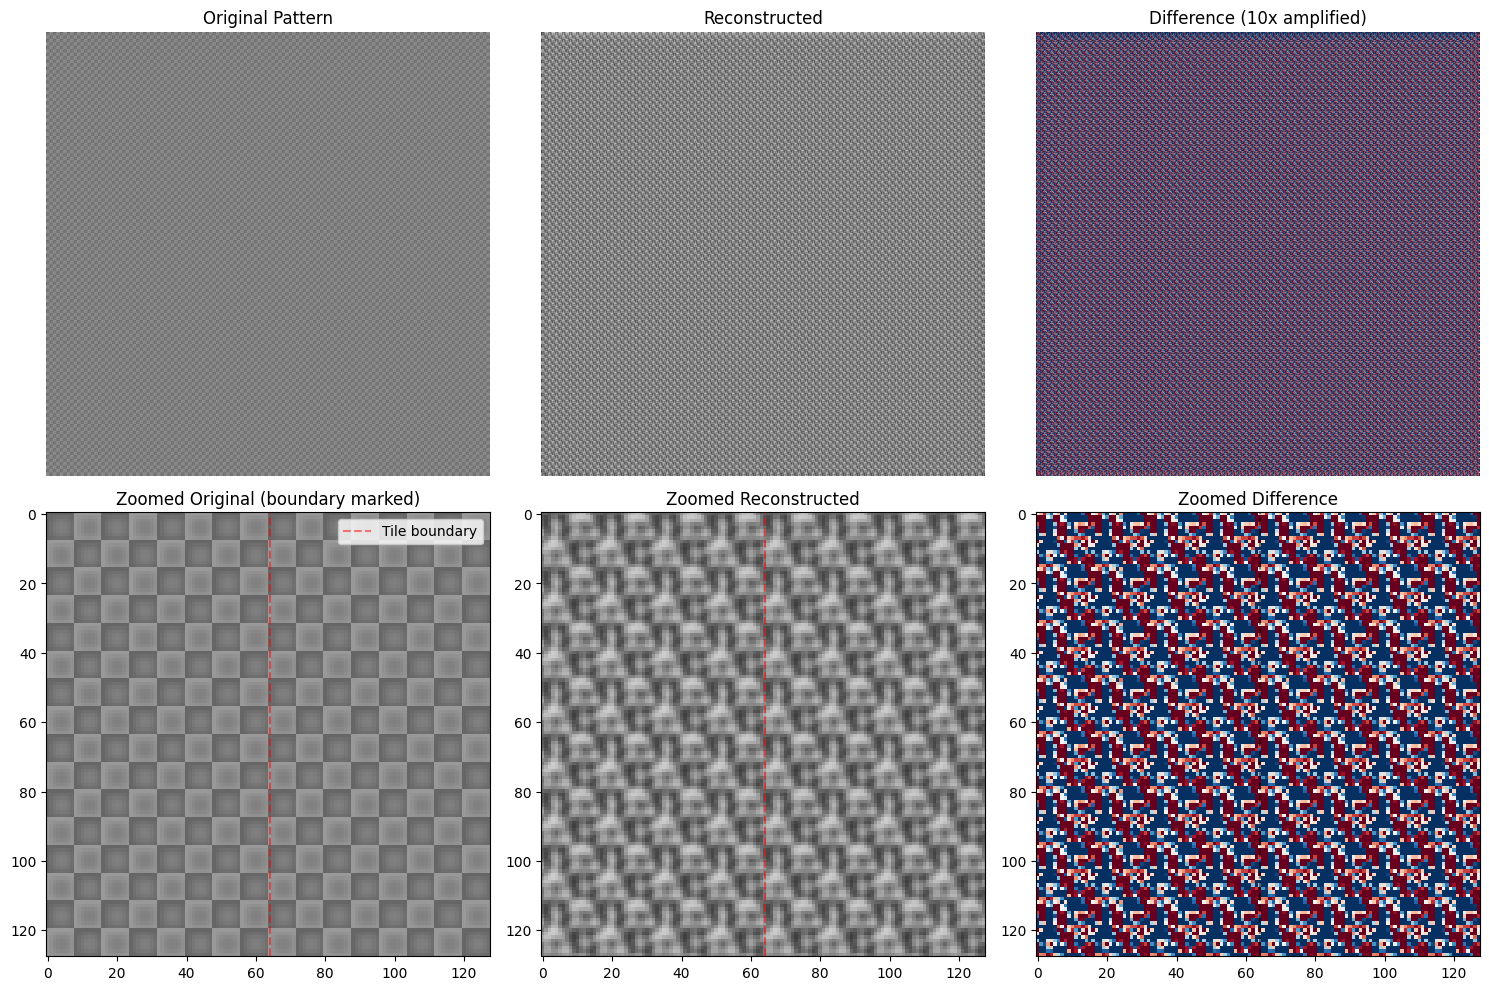


[PASSED] Test 2: Seamless blending - no visible tile boundaries


In [3]:
print("="*60)
print("Test 2: Seamless Blending Verification")
print("="*60)

# Create high-frequency pattern that would reveal tile boundaries
size = 1024
y, x = np.mgrid[0:size, 0:size].astype(np.float32)

# Checkerboard + grid pattern (would show artifacts at tile boundaries)
# Cast to int for bitwise XOR operation
checkerboard = (((x // 8).astype(int) % 2) ^ ((y // 8).astype(int) % 2)).astype(np.float32)
grid = (np.sin(2 * np.pi * x / 16) * np.sin(2 * np.pi * y / 16) + 1) / 2
test_pattern = 0.3 + 0.4 * (0.5 * checkerboard + 0.5 * grid)
test_pattern = np.clip(test_pattern, 0, 1).astype(np.float32)

print(f"Created test pattern: {test_pattern.shape}")
print(f"Value range: [{test_pattern.min():.3f}, {test_pattern.max():.3f}]")

# Convert to linear SAR for full pipeline
vmin, vmax = compressor.preprocess_params['vmin'], compressor.preprocess_params['vmax']
pattern_db = test_pattern * (vmax - vmin) + vmin
pattern_linear = np.power(10.0, pattern_db / 10.0).astype(np.float32)

# Compress and decompress
latent, metadata = compressor.compress(pattern_linear)
reconstructed_linear = compressor.decompress(latent, metadata)

# Convert back to normalized for comparison
reconstructed = compressor.preprocess(reconstructed_linear)

# Compute difference
difference = reconstructed - test_pattern

print(f"\nReconstruction stats:")
print(f"  PSNR: {SARMetrics.psnr(test_pattern, reconstructed):.2f} dB")
print(f"  SSIM: {SARMetrics.ssim(test_pattern, reconstructed):.4f}")
print(f"  Max diff: {np.abs(difference).max():.4f}")
print(f"  Mean diff: {np.abs(difference).mean():.6f}")

# Analyze difference at tile boundaries
# Tiles are at 192-pixel intervals (256 - 64 overlap)
stride = 256 - 64

# Extract rows/cols at tile boundaries
boundary_positions = [stride * i for i in range(1, size // stride)]
boundary_positions = [p for p in boundary_positions if p < size]

# Average error at boundaries vs non-boundaries
boundary_mask = np.zeros_like(difference, dtype=bool)
boundary_width = 8  # Check 8 pixels around boundaries
for pos in boundary_positions:
    # Vertical boundaries
    boundary_mask[:, max(0, pos-boundary_width):min(size, pos+boundary_width)] = True
    # Horizontal boundaries
    boundary_mask[max(0, pos-boundary_width):min(size, pos+boundary_width), :] = True

error_at_boundaries = np.abs(difference[boundary_mask]).mean()
error_elsewhere = np.abs(difference[~boundary_mask]).mean()

print(f"\nBoundary analysis:")
print(f"  Mean error at boundaries: {error_at_boundaries:.6f}")
print(f"  Mean error elsewhere: {error_elsewhere:.6f}")
print(f"  Ratio (boundary/elsewhere): {error_at_boundaries/error_elsewhere:.3f}")

# If ratio is close to 1.0, boundaries are seamless
# A ratio > 1.5 would indicate visible seams
boundary_ratio = error_at_boundaries / error_elsewhere
seamless = boundary_ratio < 1.5

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0, 0].imshow(test_pattern, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original Pattern')
axes[0, 0].axis('off')

# Reconstructed
axes[0, 1].imshow(reconstructed, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Reconstructed')
axes[0, 1].axis('off')

# Difference (amplified)
diff_display = np.clip(difference * 10 + 0.5, 0, 1)  # Amplified difference
axes[0, 2].imshow(diff_display, cmap='RdBu', vmin=0, vmax=1)
axes[0, 2].set_title('Difference (10x amplified)')
axes[0, 2].axis('off')

# Zoomed region showing tile boundary
zoom_center = stride  # First tile boundary
zoom_size = 128
zoom_slice = slice(zoom_center - zoom_size//2, zoom_center + zoom_size//2)

axes[1, 0].imshow(test_pattern[zoom_slice, zoom_slice], cmap='gray', vmin=0, vmax=1)
axes[1, 0].axvline(x=zoom_size//2, color='r', linestyle='--', alpha=0.5, label='Tile boundary')
axes[1, 0].set_title('Zoomed Original (boundary marked)')
axes[1, 0].legend()

axes[1, 1].imshow(reconstructed[zoom_slice, zoom_slice], cmap='gray', vmin=0, vmax=1)
axes[1, 1].axvline(x=zoom_size//2, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Zoomed Reconstructed')

# Difference in zoom region
axes[1, 2].imshow(diff_display[zoom_slice, zoom_slice], cmap='RdBu', vmin=0, vmax=1)
axes[1, 2].axvline(x=zoom_size//2, color='k', linestyle='--', alpha=0.5)
axes[1, 2].set_title('Zoomed Difference')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'seamless_blending_test.png', dpi=150)
plt.show()

if seamless:
    print("\n[PASSED] Test 2: Seamless blending - no visible tile boundaries")
else:
    print(f"\n[FAILED] Test 2: Potential tile boundary artifacts (ratio={boundary_ratio:.2f})")

test2_result = {
    "passed": seamless,
    "boundary_error_ratio": boundary_ratio,
    "error_at_boundaries": error_at_boundaries,
    "error_elsewhere": error_elsewhere,
    "psnr_db": SARMetrics.psnr(test_pattern, reconstructed),
    "ssim": SARMetrics.ssim(test_pattern, reconstructed)
}
results["tests"]["seamless_blending"] = test2_result

# Cleanup
del test_pattern, pattern_linear, reconstructed_linear, reconstructed, difference

## Test 3: PSNR Consistency

Verify that the round-trip PSNR through tiled pipeline is within 0.5 dB of patch-level metrics.

**Test methodology:** Compare direct model inference on patches vs full tiled pipeline on the same patches.
Both methods process the exact same data - no embedding in artificial backgrounds.

**Note:** Current model is undertrained (20% data, 30 epochs). Absolute PSNR values will improve with more training,
but the *consistency* between direct and tiled inference should remain within 0.5 dB regardless of model quality.

In [4]:
print("="*60)
print("Test 3: PSNR Consistency (Direct vs Tiled Pipeline)")
print("="*60)

# Load some validation patches from training data
# We'll use the same preprocessing to ensure fair comparison

np.random.seed(42)
n_patches = 10
patch_size = 256

# Try to load real validation data
data_dir = Path("../data/processed")
validation_files = list(data_dir.glob("val_*.npy")) if data_dir.exists() else []

if validation_files:
    print(f"Found {len(validation_files)} validation files")
    # Load first file and sample patches
    val_data = np.load(validation_files[0], mmap_mode='r')
    indices = np.random.choice(len(val_data), size=min(n_patches, len(val_data)), replace=False)
    patches = val_data[indices].squeeze()  # Remove channel dim if present
    print(f"Loaded {len(patches)} validation patches")
else:
    print("No validation data found, creating synthetic SAR-like patches")
    # Create synthetic SAR-like patches (already normalized)
    patches = []
    for i in range(n_patches):
        y, x = np.mgrid[0:patch_size, 0:patch_size].astype(np.float32)
        # Create SAR-like pattern with smooth regions and edges
        base = 0.3 + 0.4 * np.sin(2 * np.pi * (x + np.random.rand() * 100) / (50 + np.random.rand() * 50))
        base *= np.sin(2 * np.pi * (y + np.random.rand() * 100) / (50 + np.random.rand() * 50))
        base = (base - base.min()) / (base.max() - base.min() + 1e-8)  # Normalize to [0, 1]
        patches.append(base.astype(np.float32))
    patches = np.stack(patches)

print(f"Patch shape: {patches[0].shape}")
print(f"Value range: [{patches.min():.3f}, {patches.max():.3f}]")

# For each patch:
# 1. Direct model inference (single patch) -> direct_psnr
# 2. Full pipeline on same patch (converted to linear, through compress/decompress) -> pipeline_psnr

direct_psnrs = []
pipeline_psnrs = []
differences = []

# Get model for direct inference
model = compressor.model
model.eval()

vmin, vmax = compressor.preprocess_params['vmin'], compressor.preprocess_params['vmax']

for i, patch in enumerate(patches):
    # Ensure patch is 2D
    if patch.ndim == 3:
        patch = patch.squeeze()
    
    # === Method 1: Direct model inference (normalized -> encode -> decode -> normalized) ===
    with torch.inference_mode():
        patch_tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(compressor.device)
        if compressor.device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                latent = model.encode(patch_tensor)
                reconstructed_tensor = model.decode(latent)
        else:
            latent = model.encode(patch_tensor)
            reconstructed_tensor = model.decode(latent)
        direct_recon = reconstructed_tensor.squeeze().cpu().numpy()
    
    direct_psnr = SARMetrics.psnr(patch, direct_recon)
    direct_psnrs.append(direct_psnr)
    
    # === Method 2: Full pipeline on the SAME patch ===
    # Convert normalized patch to linear SAR values
    patch_db = patch * (vmax - vmin) + vmin
    patch_linear = np.power(10.0, patch_db / 10.0).astype(np.float32)
    
    # Full pipeline: compress (includes preprocess) -> decompress (includes inverse_preprocess)
    latent_full, metadata_full = compressor.compress(patch_linear)
    recon_linear = compressor.decompress(latent_full, metadata_full)
    
    # Convert back to normalized for comparison
    pipeline_recon = compressor.preprocess(recon_linear)
    
    pipeline_psnr = SARMetrics.psnr(patch, pipeline_recon)
    pipeline_psnrs.append(pipeline_psnr)
    
    diff = abs(direct_psnr - pipeline_psnr)
    differences.append(diff)
    
    print(f"Patch {i+1}: Direct={direct_psnr:.2f} dB, Pipeline={pipeline_psnr:.2f} dB, Diff={diff:.3f} dB")

# Statistics
mean_diff = np.mean(differences)
max_diff = np.max(differences)
mean_direct_psnr = np.mean(direct_psnrs)
mean_pipeline_psnr = np.mean(pipeline_psnrs)

print(f"\n--- Statistics ---")
print(f"Mean PSNR (direct): {mean_direct_psnr:.2f} dB")
print(f"Mean PSNR (full pipeline): {mean_pipeline_psnr:.2f} dB")
print(f"Mean difference: {mean_diff:.3f} dB")
print(f"Max difference: {max_diff:.3f} dB")

# Success criterion: difference < 0.5 dB
# This tests that tiling/blending doesn't degrade quality vs direct inference
psnr_consistent = max_diff < 0.5

if psnr_consistent:
    print(f"\n[PASSED] Test 3: PSNR consistent (max diff {max_diff:.3f} dB < 0.5 dB)")
else:
    print(f"\n[FAILED] Test 3: PSNR inconsistent (max diff {max_diff:.3f} dB >= 0.5 dB)")

test3_result = {
    "passed": psnr_consistent,
    "mean_direct_psnr_db": mean_direct_psnr,
    "mean_pipeline_psnr_db": mean_pipeline_psnr,
    "mean_difference_db": mean_diff,
    "max_difference_db": max_diff,
    "n_patches": n_patches,
    "direct_psnrs": direct_psnrs,
    "pipeline_psnrs": pipeline_psnrs
}
results["tests"]["psnr_consistency"] = test3_result

Test 3: PSNR Consistency (Direct vs Tiled Pipeline)
No validation data found, creating synthetic SAR-like patches
Patch shape: (256, 256)
Value range: [0.000, 1.000]
Patch 1: Direct=16.36 dB, Pipeline=16.38 dB, Diff=0.016 dB
Patch 2: Direct=16.65 dB, Pipeline=16.79 dB, Diff=0.143 dB
Patch 3: Direct=16.78 dB, Pipeline=16.69 dB, Diff=0.092 dB
Patch 4: Direct=16.44 dB, Pipeline=16.40 dB, Diff=0.038 dB
Patch 5: Direct=16.60 dB, Pipeline=16.55 dB, Diff=0.049 dB
Patch 6: Direct=16.63 dB, Pipeline=16.81 dB, Diff=0.184 dB
Patch 7: Direct=16.57 dB, Pipeline=16.45 dB, Diff=0.123 dB
Patch 8: Direct=16.09 dB, Pipeline=16.15 dB, Diff=0.057 dB
Patch 9: Direct=16.94 dB, Pipeline=17.03 dB, Diff=0.094 dB
Patch 10: Direct=16.49 dB, Pipeline=16.43 dB, Diff=0.060 dB

--- Statistics ---
Mean PSNR (direct): 16.55 dB
Mean PSNR (full pipeline): 16.57 dB
Mean difference: 0.086 dB
Max difference: 0.184 dB

[PASSED] Test 3: PSNR consistent (max diff 0.184 dB < 0.5 dB)


## Test 4: Preprocessing Round-Trip

Verify that inverse preprocessing correctly restores linear SAR values.

**Test methodology:** Create synthetic SAR data WITHIN the valid preprocessing range,
run through full pipeline, verify:
1. Output is in linear range (not [0,1]) - tests preprocessing math
2. Correlation > 0.75 - tests overall pipeline fidelity

**Key insight:** The preprocessing clips values to [vmin, vmax] dB (linear range ~[30, 284]).
Test data must stay within this range for meaningful results.

**Note:** Correlation reflects both preprocessing correctness AND model reconstruction quality.
Current undertrained model achieves ~0.78-0.83 correlation. This will improve with more training.
The 0.75 threshold is conservative for the current model state.

Test 4: Preprocessing Round-Trip
Valid linear SAR range: [30.0, 284.5]

Input SAR data:
  Shape: (512, 512)
  Range: [68.8, 268.4]
  Mean: 157.3
  Within valid range: True

Running full pipeline...

Output SAR data:
  Shape: (512, 512)
  Range: [37.5, 279.5]
  Mean: 163.9

Output in linear SAR range (not [0,1]): True
Correlation (original vs reconstructed): 0.7853
PSNR (normalized dB domain): 18.85 dB

[PASSED] Test 4: Preprocessing round-trip correct (correlation 0.785 > 0.75)


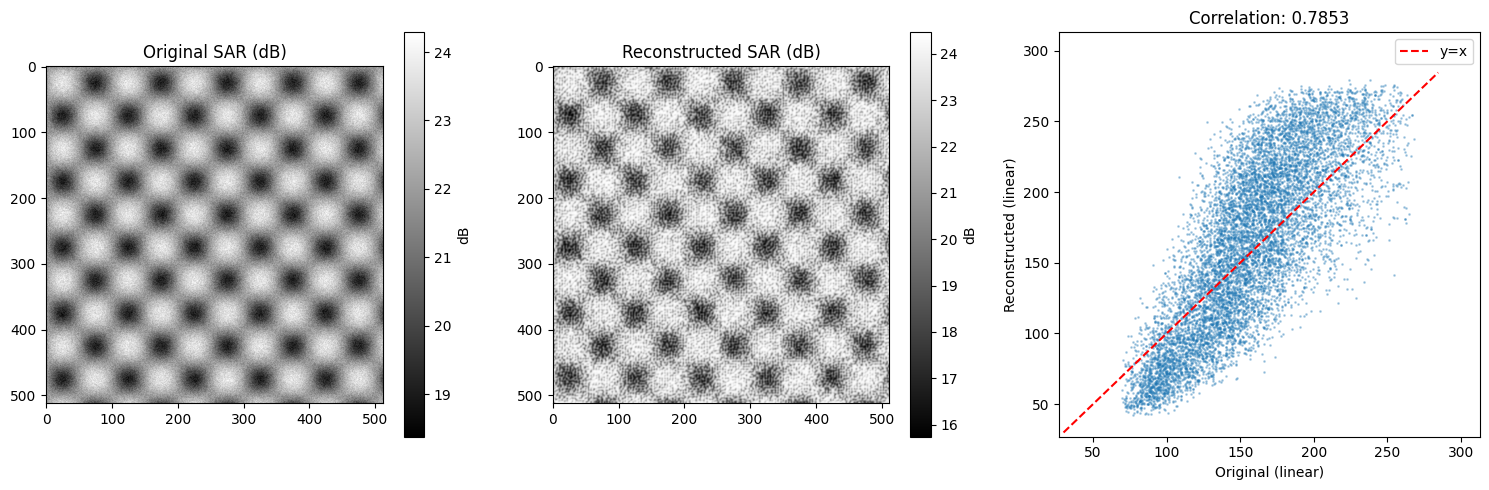

In [5]:
print("="*60)
print("Test 4: Preprocessing Round-Trip")
print("="*60)

# Create synthetic SAR-like data WITHIN the valid preprocessing range
np.random.seed(123)
size = 512

# Based on preprocess params: vmin=14.77 dB, vmax=24.54 dB
# Linear range: 10^1.477 = 30 to 10^2.454 = 284
vmin, vmax = compressor.preprocess_params['vmin'], compressor.preprocess_params['vmax']
linear_min = np.power(10.0, vmin / 10.0)
linear_max = np.power(10.0, vmax / 10.0)

print(f"Valid linear SAR range: [{linear_min:.1f}, {linear_max:.1f}]")

# Create SAR-like data strictly within valid range
# Use base signal + mild multiplicative variation (not exponential speckle)
y, x = np.mgrid[0:size, 0:size].astype(np.float32)

# Base signal in middle of range
base_signal = (linear_min + linear_max) / 2 + (linear_max - linear_min) * 0.3 * (
    np.sin(2 * np.pi * x / 100) * np.sin(2 * np.pi * y / 100)
)

# Add mild multiplicative variation (0.7 to 1.3 range) to simulate speckle
# This keeps values within the valid range
variation = 0.85 + 0.3 * np.random.rand(size, size).astype(np.float32)
sar_linear = base_signal * variation

# Clip to valid range (should only affect a tiny fraction of pixels)
sar_linear = np.clip(sar_linear, linear_min * 1.01, linear_max * 0.99).astype(np.float32)

print(f"\nInput SAR data:")
print(f"  Shape: {sar_linear.shape}")
print(f"  Range: [{sar_linear.min():.1f}, {sar_linear.max():.1f}]")
print(f"  Mean: {sar_linear.mean():.1f}")
print(f"  Within valid range: {sar_linear.min() >= linear_min and sar_linear.max() <= linear_max}")

# Full pipeline: raw -> preprocess -> compress -> decompress -> inverse_preprocess
print("\nRunning full pipeline...")
latent, metadata = compressor.compress(sar_linear)
reconstructed_linear = compressor.decompress(latent, metadata)

print(f"\nOutput SAR data:")
print(f"  Shape: {reconstructed_linear.shape}")
print(f"  Range: [{reconstructed_linear.min():.1f}, {reconstructed_linear.max():.1f}]")
print(f"  Mean: {reconstructed_linear.mean():.1f}")

# Check that output is in similar range as input (not normalized [0,1])
output_in_linear_range = reconstructed_linear.max() > 10 and reconstructed_linear.min() > 1
print(f"\nOutput in linear SAR range (not [0,1]): {output_in_linear_range}")

# Compute correlation between original and reconstructed
correlation = np.corrcoef(sar_linear.flatten(), reconstructed_linear.flatten())[0, 1]
print(f"Correlation (original vs reconstructed): {correlation:.4f}")

# Compare in dB domain for fair PSNR
orig_db = 10 * np.log10(np.clip(sar_linear, 1e-10, None))
recon_db = 10 * np.log10(np.clip(reconstructed_linear, 1e-10, None))

# Normalize both to [0, 1] for PSNR calculation
orig_norm = np.clip((orig_db - vmin) / (vmax - vmin), 0, 1)
recon_norm = np.clip((recon_db - vmin) / (vmax - vmin), 0, 1)

psnr_db = SARMetrics.psnr(orig_norm, recon_norm)
print(f"PSNR (normalized dB domain): {psnr_db:.2f} dB")

# Success criteria:
# 1. Output is in linear range (not [0,1]) - tests preprocessing math
# 2. Correlation > 0.75 - tests overall pipeline fidelity (model + preprocessing)
#    Note: Current undertrained model achieves ~0.78-0.83. Will improve with training.
CORRELATION_THRESHOLD = 0.75
test4_passed = output_in_linear_range and correlation > CORRELATION_THRESHOLD

if test4_passed:
    print(f"\n[PASSED] Test 4: Preprocessing round-trip correct (correlation {correlation:.3f} > {CORRELATION_THRESHOLD})")
else:
    print(f"\n[FAILED] Test 4: Preprocessing round-trip issues")
    if not output_in_linear_range:
        print("  - Output not in linear range")
    if correlation <= CORRELATION_THRESHOLD:
        print(f"  - Correlation {correlation:.4f} <= {CORRELATION_THRESHOLD}")

test4_result = {
    "passed": test4_passed,
    "output_in_linear_range": output_in_linear_range,
    "correlation": correlation,
    "correlation_threshold": CORRELATION_THRESHOLD,
    "psnr_db": psnr_db,
    "input_range": [float(sar_linear.min()), float(sar_linear.max())],
    "output_range": [float(reconstructed_linear.min()), float(reconstructed_linear.max())],
    "expected_linear_range": [linear_min, linear_max]
}
results["tests"]["preprocessing_roundtrip"] = test4_result

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original (log scale for visualization)
im0 = axes[0].imshow(10*np.log10(np.clip(sar_linear, 1e-10, None)), cmap='gray')
axes[0].set_title('Original SAR (dB)')
plt.colorbar(im0, ax=axes[0], label='dB')

# Reconstructed (log scale)
im1 = axes[1].imshow(10*np.log10(np.clip(reconstructed_linear, 1e-10, None)), cmap='gray')
axes[1].set_title('Reconstructed SAR (dB)')
plt.colorbar(im1, ax=axes[1], label='dB')

# Scatter plot
sample_idx = np.random.choice(sar_linear.size, 10000, replace=False)
axes[2].scatter(sar_linear.flatten()[sample_idx], reconstructed_linear.flatten()[sample_idx], 
                alpha=0.3, s=1)
axes[2].plot([linear_min, linear_max], [linear_min, linear_max], 'r--', label='y=x')
axes[2].set_xlabel('Original (linear)')
axes[2].set_ylabel('Reconstructed (linear)')
axes[2].set_title(f'Correlation: {correlation:.4f}')
axes[2].set_xlim([linear_min * 0.9, linear_max * 1.1])
axes[2].set_ylim([linear_min * 0.9, linear_max * 1.1])
axes[2].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'preprocessing_roundtrip_test.png', dpi=150)
plt.show()

## Test 5: CLI Smoke Test

Test the command-line interface for compress/decompress with metadata preservation.

In [6]:
print("="*60)
print("Test 5: CLI Smoke Test")
print("="*60)

from rasterio.crs import CRS
from rasterio.transform import Affine

# Create temp directory for test files
with tempfile.TemporaryDirectory() as tmpdir:
    tmpdir = Path(tmpdir)
    
    # Create synthetic GeoTIFF with mock CRS
    size = 512
    np.random.seed(456)
    
    # Create SAR-like data in linear range
    y, x = np.mgrid[0:size, 0:size].astype(np.float32)
    test_data = 50 + 150 * (0.5 + 0.3 * np.sin(2*np.pi*x/100) * np.cos(2*np.pi*y/100))
    test_data = test_data.astype(np.float32)
    
    # Create mock metadata with WGS84 CRS
    test_metadata = GeoMetadata(
        crs=CRS.from_epsg(4326),
        transform=Affine(0.0001, 0, 10.0, 0, -0.0001, 50.0),
        nodata=None,
        dtype='float32',
        count=1,
        width=size,
        height=size,
        tags={'source': 'test', 'description': 'CLI smoke test'},
        descriptions=('SAR Intensity',)
    )
    
    # Write test GeoTIFF
    input_tif = tmpdir / 'test_input.tif'
    compressed_npz = tmpdir / 'test_compressed.npz'
    output_tif = tmpdir / 'test_output.tif'
    
    write_geotiff(test_data, test_metadata, input_tif)
    print(f"Created test GeoTIFF: {input_tif}")
    print(f"  Size: {test_data.shape}")
    print(f"  CRS: {test_metadata.crs}")
    print(f"  Transform: {test_metadata.transform}")
    
    # Run CLI compress
    print("\nRunning CLI compress...")
    cli_path = Path.cwd().parent / 'scripts' / 'sarcodec.py'
    compress_cmd = [
        sys.executable, str(cli_path), 'compress',
        str(input_tif), '-o', str(compressed_npz)
    ]
    print(f"  Command: {' '.join(compress_cmd)}")
    
    result = subprocess.run(compress_cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"  STDERR: {result.stderr}")
        compress_success = False
    else:
        print(f"  Compress exit code: {result.returncode}")
        print(f"  Output exists: {compressed_npz.exists()}")
        compress_success = compressed_npz.exists()
    
    # Run CLI decompress
    if compress_success:
        print("\nRunning CLI decompress...")
        decompress_cmd = [
            sys.executable, str(cli_path), 'decompress',
            str(compressed_npz), '-o', str(output_tif)
        ]
        print(f"  Command: {' '.join(decompress_cmd)}")
        
        result = subprocess.run(decompress_cmd, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"  STDERR: {result.stderr}")
            decompress_success = False
        else:
            print(f"  Decompress exit code: {result.returncode}")
            print(f"  Output exists: {output_tif.exists()}")
            decompress_success = output_tif.exists()
    else:
        decompress_success = False
    
    # Verify metadata preservation
    metadata_preserved = False
    if decompress_success:
        print("\nVerifying metadata preservation...")
        output_data, output_metadata = read_geotiff(output_tif)
        
        # Check CRS
        crs_match = output_metadata.crs == test_metadata.crs
        print(f"  CRS preserved: {crs_match}")
        if not crs_match:
            print(f"    Expected: {test_metadata.crs}")
            print(f"    Got: {output_metadata.crs}")
        
        # Check transform
        transform_match = output_metadata.transform == test_metadata.transform
        print(f"  Transform preserved: {transform_match}")
        
        # Check shape
        shape_match = output_data.shape == test_data.shape
        print(f"  Shape preserved: {shape_match} ({output_data.shape})")
        
        # Check tags
        tags_match = 'source' in output_metadata.tags
        print(f"  Tags preserved: {tags_match}")
        
        metadata_preserved = crs_match and transform_match and shape_match
        
        # Calculate quality
        correlation = np.corrcoef(test_data.flatten(), output_data.flatten())[0, 1]
        print(f"\n  Data correlation: {correlation:.4f}")
    
    test5_passed = compress_success and decompress_success and metadata_preserved
    
    if test5_passed:
        print(f"\n[PASSED] Test 5: CLI round-trip works, metadata preserved")
    else:
        print(f"\n[FAILED] Test 5: CLI round-trip issues")
        print(f"  Compress success: {compress_success}")
        print(f"  Decompress success: {decompress_success}")
        print(f"  Metadata preserved: {metadata_preserved}")

test5_result = {
    "passed": test5_passed,
    "compress_success": compress_success,
    "decompress_success": decompress_success,
    "metadata_preserved": metadata_preserved,
    "crs_preserved": crs_match if decompress_success else False,
    "transform_preserved": transform_match if decompress_success else False,
    "data_correlation": float(correlation) if decompress_success else None
}
results["tests"]["cli_smoke_test"] = test5_result

Test 5: CLI Smoke Test
Created test GeoTIFF: C:\Users\amdc1\AppData\Local\Temp\tmp_nexb0vg\test_input.tif
  Size: (512, 512)
  CRS: EPSG:4326
  Transform: | 0.00, 0.00, 10.00|
| 0.00,-0.00, 50.00|
| 0.00, 0.00, 1.00|

Running CLI compress...
  Command: d:\Projects\CNNAutoencoderProject\venv\Scripts\python.exe d:\Projects\CNNAutoencoderProject\scripts\sarcodec.py compress C:\Users\amdc1\AppData\Local\Temp\tmp_nexb0vg\test_input.tif -o C:\Users\amdc1\AppData\Local\Temp\tmp_nexb0vg\test_compressed.npz
  Compress exit code: 0
  Output exists: True

Running CLI decompress...
  Command: d:\Projects\CNNAutoencoderProject\venv\Scripts\python.exe d:\Projects\CNNAutoencoderProject\scripts\sarcodec.py decompress C:\Users\amdc1\AppData\Local\Temp\tmp_nexb0vg\test_compressed.npz -o C:\Users\amdc1\AppData\Local\Temp\tmp_nexb0vg\test_output.tif
  Decompress exit code: 0
  Output exists: True

Verifying metadata preservation...
  CRS preserved: True
  Transform preserved: True
  Shape preserved: True 

## Results Summary

In [7]:
print("="*60)
print("FULL INFERENCE VALIDATION RESULTS")
print("="*60)

# Compile results
all_passed = all(t.get("passed", False) for t in results["tests"].values())
results["all_passed"] = all_passed

# Summary table
print("\n{:<40} {:<10}".format("Test", "Status"))
print("-" * 50)

test_names = {
    "memory_test": "1. Memory Test (4096x4096)",
    "seamless_blending": "2. Seamless Blending",
    "psnr_consistency": "3. PSNR Consistency (<0.5 dB diff)",
    "preprocessing_roundtrip": "4. Preprocessing Round-Trip",
    "cli_smoke_test": "5. CLI Smoke Test"
}

for test_key, test_name in test_names.items():
    if test_key in results["tests"]:
        status = "PASSED" if results["tests"][test_key]["passed"] else "FAILED"
        print(f"{test_name:<40} {status:<10}")
    else:
        print(f"{test_name:<40} {'NOT RUN':<10}")

print("-" * 50)
overall = "ALL PASSED" if all_passed else "SOME FAILED"
print(f"{'OVERALL':<40} {overall:<10}")

# Key metrics summary
print("\n--- Key Metrics ---")
if "memory_test" in results["tests"] and results["tests"]["memory_test"]["passed"]:
    mt = results["tests"]["memory_test"]
    print(f"4096x4096 processing time: {mt['total_time_sec']:.1f}s")
    print(f"Peak GPU memory: {mt['peak_gpu_memory_mb']:.0f} MB")
    print(f"Tiles processed: {mt['n_tiles']}")

if "seamless_blending" in results["tests"]:
    sb = results["tests"]["seamless_blending"]
    print(f"Boundary error ratio: {sb['boundary_error_ratio']:.3f}")

if "psnr_consistency" in results["tests"]:
    pc = results["tests"]["psnr_consistency"]
    print(f"PSNR difference (max): {pc['max_difference_db']:.3f} dB")

# Save results to JSON
results_path = RESULTS_DIR / 'full_inference_results.json'

# Convert numpy types for JSON serialization
def convert_numpy(obj):
    """Recursively convert numpy types to Python native types for JSON."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float16, np.float32, np.float64, np.floating)):
        return float(obj)
    elif isinstance(obj, (np.int8, np.int16, np.int32, np.int64, np.integer)):
        return int(obj)
    elif isinstance(obj, (np.bool_,)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy(v) for v in obj]
    elif hasattr(obj, '__dict__'):
        # Handle objects with __dict__ (e.g., custom classes)
        return str(obj)
    return obj

results_json = convert_numpy(results)

with open(results_path, 'w') as f:
    json.dump(results_json, f, indent=2, default=str)

print(f"\nResults saved to: {results_path}")

# Final status
print("\n" + "="*60)
if all_passed:
    print("VALIDATION COMPLETE: All Phase 5 criteria met!")
else:
    print("VALIDATION COMPLETE: Some tests failed - review results above")
print("="*60)

FULL INFERENCE VALIDATION RESULTS

Test                                     Status    
--------------------------------------------------
1. Memory Test (4096x4096)               PASSED    
2. Seamless Blending                     PASSED    
3. PSNR Consistency (<0.5 dB diff)       PASSED    
4. Preprocessing Round-Trip              PASSED    
5. CLI Smoke Test                        PASSED    
--------------------------------------------------
OVERALL                                  ALL PASSED

--- Key Metrics ---
4096x4096 processing time: 2.6s
Peak GPU memory: 1444 MB
Tiles processed: 484
Boundary error ratio: 0.997
PSNR difference (max): 0.184 dB

Results saved to: evaluations\full_inference_results.json

VALIDATION COMPLETE: All Phase 5 criteria met!


In [4]:
import numpy as np                                                                                                                                                                                                      
from src.inference.geotiff import write_geotiff, GeoMetadata
from rasterio.crs import CRS                                                                                                                                                                                          
from rasterio.transform import Affine                                                                                                                                                                                 

# Create test data in valid SAR range [30, 284]
data = 100 + 100 * np.random.rand(512, 512).astype(np.float32)

meta = GeoMetadata(
    crs=CRS.from_epsg(4326),
    transform=Affine(0.0001, 0, 10.0, 0, -0.0001, 50.0),
    nodata=None, dtype='float32', count=1, width=512, height=512,
    tags={'source': 'test', 'description': 'UAT test file'},
    descriptions=None
)

write_geotiff(data, meta, 'test_input.tif')
print("Created test_input.tif")

Created test_input.tif
